## Load and Clean Data

In [1]:
import pickle

In [1]:
import pandas as pd
import keras
import numpy as np
import matplotlib.pyplot as plt  

Using TensorFlow backend.


In [2]:
reddit = pd.read_json("./data.json")

In [3]:
reddit.comments = [x[:40] for x in reddit.comments]

In [4]:
lst_col_ga = 'comments'

df = reddit

reddit = pd.DataFrame({
     col:np.repeat(df[col].values, df[lst_col_ga].str.len())
     for col in df.columns.drop(lst_col_ga)}
   ).assign(**{lst_col_ga:np.concatenate(df[lst_col_ga].values)})[df.columns].dropna().reset_index(drop = True)

In [5]:
reddit.comments = [x.replace("\n", '').replace("\t", '') for x in reddit.comments]
reddit.title = [x.replace("\n", '').replace("\t", '') for x in reddit.title]

In [6]:
reddit[['comments', 'title']].to_csv('reddit.csv', sep="\t", header=False, index=False)

In [7]:
len(reddit.title)

27430

In [8]:
comm_len = [len(x) for x in reddit.comments]

In [9]:
np.clip(comm_len, a_min= 0, a_max=2000)

array([1423,   36,  263, ...,   24,  245,  190])

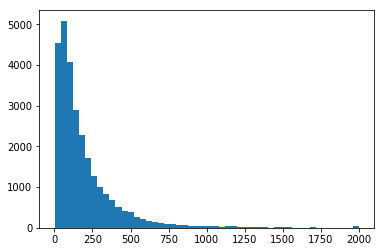

In [10]:
plt.hist(np.clip(comm_len, a_min= 0, a_max=2000), bins=50)
plt.show()

In [11]:
import string
import re
from pickle import dump
from unicodedata import normalize
from numpy import array

# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, mode='rt', encoding='utf-8')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

# split a loaded document into sentences
def to_pairs(doc):
	lines = doc.strip().split('\n')
	pairs = [line.split('\t') for line in  lines]
	return pairs

# clean a list of lines
def clean_pairs(lines):
	cleaned = list()
	# prepare regex for char filtering
	re_print = re.compile('[^%s]' % re.escape(string.printable))
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for pair in lines:
		clean_pair = list()
		for line in pair:
			# normalize unicode characters
			line = normalize('NFD', line).encode('ascii', 'ignore')
			line = line.decode('UTF-8')
			# tokenize on white space
			line = line.split()
			# convert to lowercase
			line = [word.lower() for word in line]
			# remove punctuation from each token
			line = [word.translate(table) for word in line]
			# remove non-printable chars form each token
			line = [re_print.sub('', w) for w in line]
			# remove tokens with numbers in them
			line = [word for word in line if word.isalpha()]
# 			store as string
			clean_pair.append(' '.join(line))
		if len(clean_pair) == 2:
			 cleaned.append(clean_pair)
	return array(cleaned)

# save a list of clean sentences to file
def save_clean_data(sentences, filename):
	dump(sentences, open(filename, 'wb'))
	print('Saved: %s' % filename)

# load dataset
filename = './reddit.csv'
doc = load_doc(filename)
# split into english-german pairs
pairs = to_pairs(doc)
# clean sentences
clean_pairs = clean_pairs(pairs)
# save clean pairs to file
save_clean_data(clean_pairs, 'english-german.pkl')
# spot check
for i in range(100):
	print('[%s] => [%s]' % (clean_pairs[i,0], clean_pairs[i,1]))

Saved: english-german.pkl
[i dont even know what to say rtoastme community you have all blown my mind and touched my heart when i posted this i was just sharing little bit of myself and didnt expect much response cause there are others who deserve love and are going through tough timesi absolutely did not expect to have people share so much love with me i didnt expect so many to tell me that a smile and a story was helping them with tough times i didnt expect to switch between smiling until my cheeks hurt and shedding loving tears because of the absolute love that was sent my way a beautiful soul gifted me with a gold award another gifted me with a platinum award i never thought anyone would ever think i deserved such things because they cost real money to gift i am astonished to everyone who has upvotes this commented such beautiful compliments and so many who shared their own stories and pains and achievements thank you all so freaking much i am humbled beyond words by you all i love

In [12]:
clean_pairs[21404]

array(['i actually really like your smile it makes me happy',
       'quite new to reddit thought this might be a good place to start been battlingcoming to terms with dysmorphiacould use a pickmeup'],
      dtype='<U7837')

In [13]:
([len(x) for x in clean_pairs if len(x) == 1])

[]

# Load, Reduce, and Split Clean Data

In [14]:
from pickle import load
from pickle import dump
from numpy.random import rand
from numpy.random import shuffle

# load a clean dataset
def load_clean_sentences(filename):
    return load(open(filename, 'rb'))

# # save a list of clean sentences to file
def save_clean_data(sentences, filename):
    dump(sentences, open(filename, 'wb'))
    print('Saved: %s' % filename)

# load dataset
raw_dataset = load_clean_sentences('english-german.pkl')

# reduce dataset size
n_sentences = 10000
dataset =  clean_pairs   #raw_dataset[:n_sentences, :]
# random shuffle
shuffle(dataset)
# split into train/test
train, test = dataset[:20000], dataset[20000:]
# save
save_clean_data(dataset, 'english-german-both.pkl')
save_clean_data(train, 'english-german-train.pkl')
save_clean_data(test, 'english-german-test.pkl')

Saved: english-german-both.pkl
Saved: english-german-train.pkl
Saved: english-german-test.pkl


In [15]:
import os
from pickle import load
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint

In [16]:
glove_dir = '../../../ExamStudy/data/glove.6B/'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [17]:
maxlen = 100  # We will cut reviews after 100 words
training_samples = 20000  # We will be training on 200 samples
validation_samples = 5000  # We will be validating on 10000 samples
max_words = 1000

In [18]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(dataset[:, 0:2].ravel())
sequences = tokenizer.texts_to_sequences(dataset[:, 0:2].ravel())

In [21]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 24568 unique tokens.


In [20]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

## Train

In [ ]:


# load a clean dataset
def load_clean_sentences(filename):
	return load(open(filename, 'rb'))

# fit a tokenizer
def create_tokenizer(lines):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

# max sentence length
def max_length(lines):
	return max(len(line.split()) for line in lines)

# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
	# integer encode sequences
	X = tokenizer.texts_to_sequences(lines)
	# pad sequences with 0 values
	X = pad_sequences(X, maxlen=length, padding='post')
	return X

# one hot encode target sequence
def encode_output(sequences, vocab_size):
	ylist = list()
	for sequence in sequences:
		encoded = to_categorical(sequence, num_classes=vocab_size)
		ylist.append(encoded)
	y = array(ylist)
	y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
	return y

# define NMT model
def define_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
    
	model = Sequential()
	model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True, 
                        weights = [embedding_matrix], trainable = False))
#     model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
	model.add(LSTM(n_units))
	model.add(RepeatVector(tar_timesteps))
	model.add(LSTM(n_units, return_sequences=True))
	model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
	return model

# load datasets
dataset = load_clean_sentences('english-german-both.pkl')
train = load_clean_sentences('english-german-train.pkl')
test = load_clean_sentences('english-german-test.pkl')

# prepare english tokenizer
# eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(tokenizer.word_index) + 1
eng_length = 1000#max_length(dataset[:, 0])
print('English Vocabulary Size: %d' % eng_vocab_size)
print('English Max Length: %d' % (eng_length))
# prepare german tokenizer
# ger_tokenizer = create_tokenizer(dataset[:, 1])
ger_vocab_size = len(tokenizer.word_index) + 1
ger_length = 1000#max_length(dataset[:, 1])
print('German Vocabulary Size: %d' % ger_vocab_size)
print('German Max Length: %d' % (ger_length))

# prepare training data
trainX = encode_sequences(tokenizer, ger_length, train[:, 1])
trainY = encode_sequences(tokenizer, eng_length, train[:, 0])
trainY = encode_output(trainY, eng_vocab_size)
# prepare validation data
testX = encode_sequences(tokenizer, ger_length, test[:, 1])
testY = encode_sequences(tokenizer, eng_length, test[:, 0])
testY = encode_output(testY, eng_vocab_size)

# define model
model = define_model(ger_vocab_size, eng_vocab_size, ger_length, eng_length, 128)
model.compile(optimizer='adam', loss='categorical_crossentropy')
# summarize defined model
print(model.summary())


English Vocabulary Size: 24569
English Max Length: 1000
German Vocabulary Size: 24569
German Max Length: 1000


In [ ]:
#plot_model(model, to_file='model.png', show_shapes=True)
# fit model
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
model.fit(trainX, trainY, epochs=1, batch_size=64, validation_data=(testX, testY), 
          callbacks=[checkpoint], verbose=1)

# Evaluation

In [24]:
from pickle import load
from numpy import array
from numpy import argmax
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu

# load a clean dataset
def load_clean_sentences(filename):
	return load(open(filename, 'rb'))

# fit a tokenizer
def create_tokenizer(lines):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

# max sentence length
def max_length(lines):
	return max(len(line.split()) for line in lines)

# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
	# integer encode sequences
	X = tokenizer.texts_to_sequences(lines)
	# pad sequences with 0 values
	X = pad_sequences(X, maxlen=length, padding='post')
	return X

# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

# generate target given source sequence
def predict_sequence(model, tokenizer, source):
	prediction = model.predict(source, verbose=0)[0]
	integers = [argmax(vector) for vector in prediction]
	target = list()
	for i in integers:
		word = word_for_id(i, tokenizer)
		if word is None:
			break
		target.append(word)
	return ' '.join(target)

# evaluate the skill of the model
def evaluate_model(model, tokenizer, sources, raw_dataset):
	actual, predicted = list(), list()
	for i, source in enumerate(sources):
		# translate encoded source text
		source = source.reshape((1, source.shape[0]))
		translation = predict_sequence(model, eng_tokenizer, source)
		raw_target, raw_src = raw_dataset[i]
		if i < 10:
			print('src=[%s], target=[%s], predicted=[%s]' % (raw_src, raw_target, translation))
		actual.append([raw_target.split()])
		predicted.append(translation.split())
	# calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

# load datasets
dataset = load_clean_sentences('english-german-both.pkl')
train = load_clean_sentences('english-german-train.pkl')
test = load_clean_sentences('english-german-test.pkl')
# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])
# prepare german tokenizer
ger_tokenizer = create_tokenizer(dataset[:, 1])
ger_vocab_size = len(ger_tokenizer.word_index) + 1
ger_length = max_length(dataset[:, 1])
# prepare data
trainX = encode_sequences(ger_tokenizer, ger_length, train[:, 1])
testX = encode_sequences(ger_tokenizer, ger_length, test[:, 1])

# load model
model = load_model('model.h5')
# test on some training sequences
print('train')
evaluate_model(model, eng_tokenizer, trainX, train)
# test on some test sequences
print('test')
evaluate_model(model, eng_tokenizer, testX, test)

train
src=[listen man i have no reason to lie it doesnt benefit me in any way you are attractive you are and i have no doubt that someone else will find you or vice versa keep trying youll get there], target=[i was beginning to conquer my depression and i had the biggest support from my boyfriend but we broke up and ive been spiralling since anxiety and insecurities kick me down and tell me i wont find love and wont get better some toasting would be much appreciated], predicted=[]
src=[breakups are hard but you need to accept that people come and go whatever happens its for the good so just stay tuned and keep going you look so strong i know you can get over this], target=[feeling pathetic even as i write this going thru an awful break up and the anxiety is overwhelming just want to feel that im worth something just want a distraction to get me thru today could you some toasting thank you in advance], predicted=[]
src=[you look lovely can i ask what people are saying thats upsetting yo

KeyboardInterrupt: 

In [61]:
def predict_sequence(model, tokenizer, source):
	prediction = model.predict(source, verbose=0)[0]
	print(prediction)
	integers = [np.argmax(vector) for vector in prediction]
	print(integers)
	target = list()
	for i in integers:
		word = word_for_id(i, tokenizer)
		if word is None:
			break
		target.append(word)
	return ' '.join(target)

In [32]:
sample_pred_txt = ["hello i am sad today need some kind words"]

In [36]:
sample_pred_txt = encode_sequences(eng_tokenizer, 1531, sample_pred_txt)

In [62]:
predict_sequence(model, eng_tokenizer, sample_pred_txt)

[[4.67725769e-02 2.28690691e-02 1.57457013e-02 ... 2.43741597e-05
  3.27524285e-05 2.78582065e-05]
 [1.32933974e-01 3.84270027e-02 2.82789599e-02 ... 7.85659449e-06
  1.06466805e-05 9.53474319e-06]
 [1.72415331e-01 3.75424102e-02 3.06620076e-02 ... 6.18893455e-06
  8.05057425e-06 7.75016997e-06]
 ...
 [6.26682818e-01 1.45009588e-02 1.07178641e-02 ... 3.06589095e-06
  2.81753341e-06 3.56833925e-06]
 [6.26792729e-01 1.44970333e-02 1.07142255e-02 ... 3.06507218e-06
  2.81687471e-06 3.56710007e-06]
 [6.26892865e-01 1.44934766e-02 1.07109342e-02 ... 3.06433412e-06
  2.81627968e-06 3.56597616e-06]]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


''

In [37]:
model.predict(sample_pred_txt, verbose=1)

1/1 [==============================] - 0s 190ms/step


array([[[4.67725769e-02, 2.28690691e-02, 1.57457013e-02, ...,
         2.43741597e-05, 3.27524285e-05, 2.78582065e-05],
        [1.32933974e-01, 3.84270027e-02, 2.82789599e-02, ...,
         7.85659449e-06, 1.06466805e-05, 9.53474319e-06],
        [1.72415331e-01, 3.75424102e-02, 3.06620076e-02, ...,
         6.18893455e-06, 8.05057425e-06, 7.75016997e-06],
        ...,
        [6.26682818e-01, 1.45009588e-02, 1.07178641e-02, ...,
         3.06589095e-06, 2.81753341e-06, 3.56833925e-06],
        [6.26792729e-01, 1.44970333e-02, 1.07142255e-02, ...,
         3.06507218e-06, 2.81687471e-06, 3.56710007e-06],
        [6.26892865e-01, 1.44934766e-02, 1.07109342e-02, ...,
         3.06433412e-06, 2.81627968e-06, 3.56597616e-06]]], dtype=float32)

## Questions

### How much effort is put into data preparation vs. actually training and evaluating the model?
In the the tutorial that we followed, not too much effort was put into data preparation. Most of the effort was simply lowercasing, removing punctuation, removing non-printable characters, and removing numbers. We could do a lot more of data preparation by trying to lemmatize/stem, finding POS tags, getting the dependency parsing, and more. Training and evaluating the model takes the bulk of the effort in this tutorial, as we need to worry about how to create the model and using the BLEU score to evaluate it. 

### What constitutes the input features? What constitutes the top layer?
The input features are made up of tokenized German words. Each word in an example is converted into an arbitrary list of numbers by the Keras Tokenizer. The output is also a list of tokenized words, but these words are in English and then they are also one-hot encoded so they work with the softmax in the model. 

### What does it mean that this is a "generative" classifier? How is that different from a discriminative classifier?
A generative classifier creates output based on both the input data and the previous outputs of the model. This is necessary for our LSTM because it has to generate word w based on word w-1, which it also predicted. A discriminative classifer generates output only based on the input data, and 

### How do you know your model works? What does a BLEU metric tell you? Can you think of a better way to evaluate MT output?
I know that my model works based on the BLEU metrics. This metric tells me how closely the predicted translation matches the target translation. This is not an exact match score, but it gives credit for a translation that is mostly the same. The higher the BLEU score, the better the predicted translation matches the target translation. There are different BLEU metrics for the different n-grams (BLEU-1, BLEU-2, etc). 

In [5]:
from client.api.notebook import Notebook
ok = Notebook('a8.ok')
ok.auth(inline=True)

Assignment: A8 Machine Translation with Keras
OK, version v1.13.11

Successfully logged in as DanieleMoro@u.boisestate.edu


In [6]:
ok.submit()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'A8-machine-translation-keras.ipynb'.
Submit... 0.0% complete
Could not submit: Assignment does not exist

